# Free Recall

In [49]:
import math

def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (float('nan'), float('nan'))
    p = k / n
    denom = 1 + (z**2) / n
    center = (p + (z**2) / (2 * n)) / denom
    half_width = (z * math.sqrt((p * (1 - p) + (z**2) / (4 * n)) / n)) / denom
    return (center - half_width, center + half_width)

Read all files (trials) in the specified folder and for each of them calculate the number of correct guesses and the corresponding flags (1 in the position of samples correctly guessed in any position).

In [50]:
import pandas as pd
from pathlib import Path

base = Path('..') / 'data' / 'free'

# process the root batch and each immediate subfolder
modifiers = [base] + sorted([p for p in base.iterdir() if p.is_dir()])

# collect results for every batch (no printing / plotting here)
results = {}
for mod in modifiers:
    res = []
    for trial in sorted(mod.glob('*.csv')):
        df = pd.read_csv(trial)
        guesses = set(df['guess'].dropna().astype(str))
        samples = df['sample'].astype(str)
        binaries = [1 if s in guesses else 0 for s in samples]
        total_correct = sum(binaries)
        res.append({'file': str(trial), 'counts': total_correct, 'binaries': binaries})

    results[mod.name] = res

Computes per-trial and overall summary statistics (mean, population variance, overall proportion and Wilson 95% CI) of correct guesses and prints them.

In [62]:
import pandas as pd

# Build a summary table with one row per modifier
summary_rows = []
for mod, res in results.items():
    counts = [r['counts'] for r in res]
    mean_counts = sum(counts) / len(counts) if len(counts) > 0 else float('nan')

    total_successes = sum(r['counts'] for r in res)
    total_positions = sum(len(r['binaries']) for r in res)
    proportion = total_successes / total_positions if total_positions > 0 else float('nan')
    ci = wilson_ci(total_successes, total_positions)

    summary_rows.append({
        'modifier': mod,
        'mean_counts': mean_counts,
        'proportion': proportion,
        'ci': ci,
    })

summary_df = pd.DataFrame(summary_rows)
# reorder columns for readability
summary_df = summary_df[[ 'modifier', 'mean_counts', 'proportion', 'ci']]

# display the table (Jupyter will render the DataFrame)
summary_df

,modifier,mean_counts,proportion,ci
0,free,6.50,0.3250,"(0.28095249494205327, 0.372376929267835)"
1,delay,6.10,0.3050,"(0.2619118577039247, 0.3517980721299507)"
2,rate,6.35,0.3175,"(0.2738010081305544, 0.36467110568832906)"
3,task,3.00,0.1500,"(0.11834447398799032, 0.18831437443178617)"


Plot the frequency of each correct guess based on the position

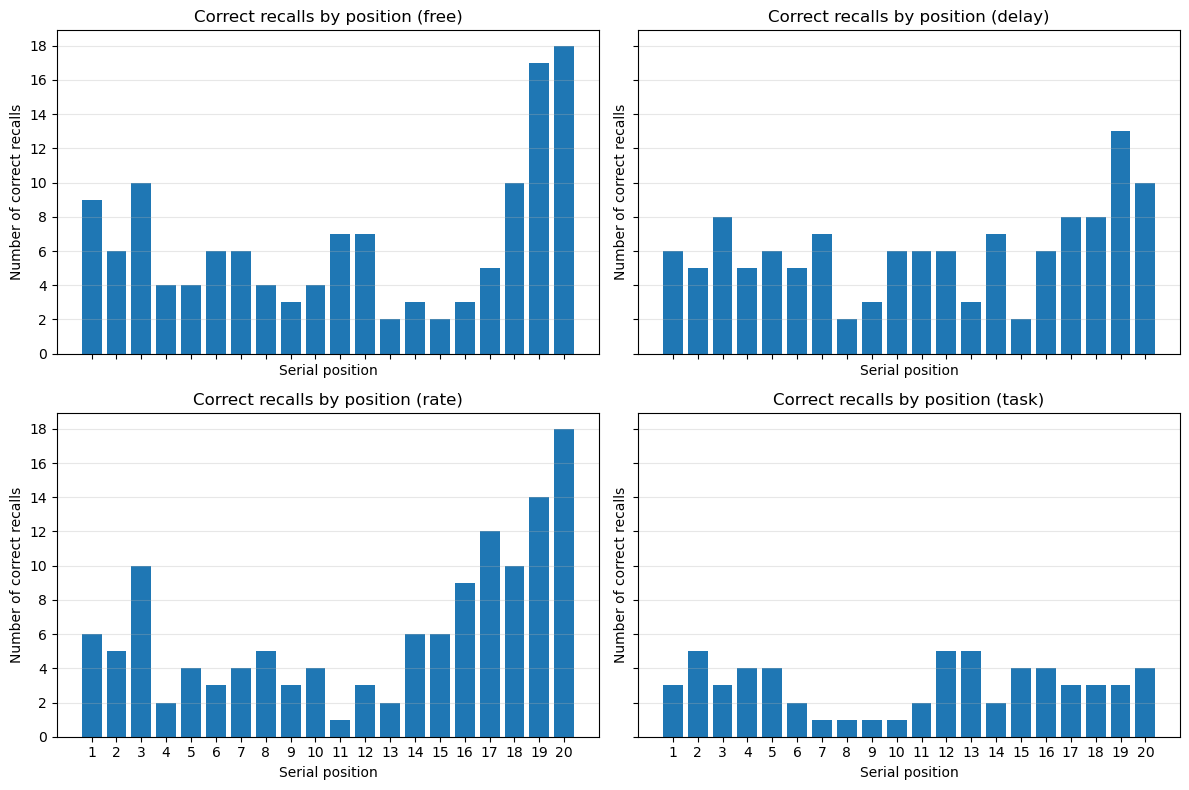

In [58]:
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Plot serial-position bar charts for each modifier in a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

positions = list(range(1, 21))

for ax, (mod, res) in zip(axs, results.items()):
    # position counts (1..20)
    pos_counts = [0] * 20
    for r in res:
        bins = r['binaries']
        for i in range(min(20, len(bins))):
            pos_counts[i] += int(bins[i])

    ax.bar(positions, pos_counts)
    ax.set_xlabel('Serial position')
    ax.set_ylabel('Number of correct recalls')
    ax.set_xticks(positions)
    ax.set_title(f'Correct recalls by position ({mod})')
    ax.grid(axis='y', alpha=0.3)

    # ensure y-axis uses integer ticks and starts at 0
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(bottom=0)

# If there are any unused axes (fewer than 4 modifiers), hide them
for ax in axs[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()